In [2]:
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import numpy as np
import math
import gym

/opt/homebrew/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


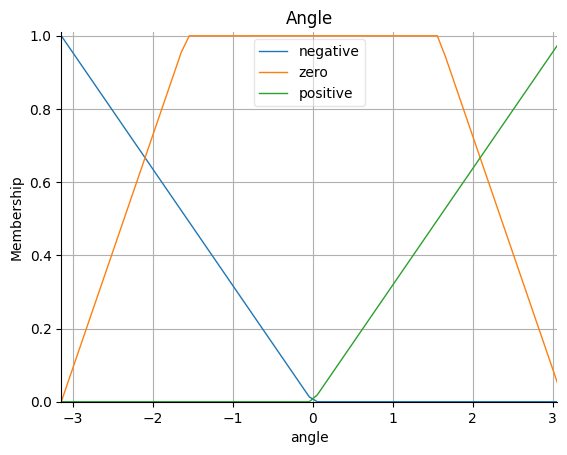

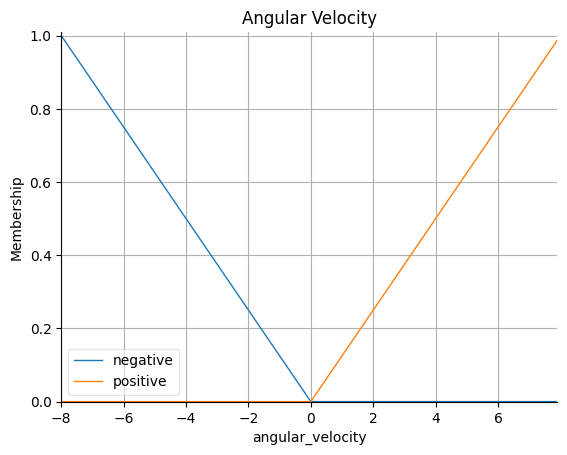

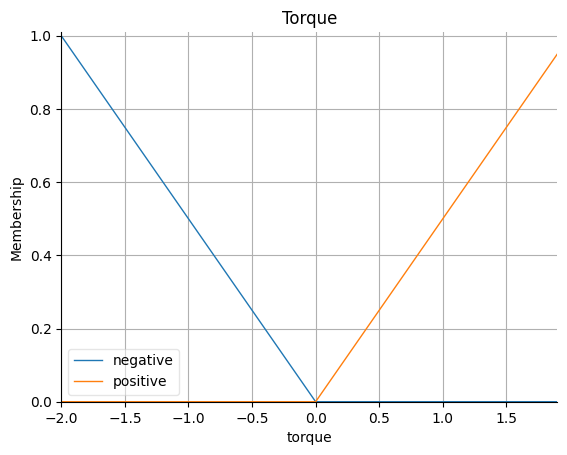

In [3]:
# Define linguistic variables for 'angle'
angle_universe = np.arange(-np.pi, np.pi, 0.1)
angle = ctrl.Antecedent(angle_universe, 'angle')
angle['negative'] = fuzz.trimf(angle.universe, [-np.pi, -np.pi, 0])
angle['zero'] = fuzz.trapmf(angle.universe, [-np.pi, -np.pi / 2, np.pi / 2, np.pi])
angle['positive'] = fuzz.trimf(angle.universe, [0, np.pi, np.pi])

# Visualize the membership functions for 'angle'
angle.view()
plt.title('Angle')
plt.grid(True)
plt.show()

# Define linguistic variables for 'angular_velocity'
angular_velocity_universe = np.arange(-8, 8, 0.1)
angular_velocity = ctrl.Antecedent(angular_velocity_universe, 'angular_velocity')
angular_velocity['negative'] = fuzz.trimf(angular_velocity.universe, [-8, -8, 0])
angular_velocity['positive'] = fuzz.trimf(angular_velocity.universe, [0, 8, 8])

# Visualize the membership functions for 'angular_velocity'
angular_velocity.view()
plt.title('Angular Velocity')
plt.grid(True)
plt.show()

# Define linguistic variables for 'torque'
torque_universe = np.arange(-2, 2, 0.1)
torque = ctrl.Consequent(torque_universe, 'torque')
torque['negative'] = fuzz.trimf(torque.universe, [-2, -2, 0])
torque['positive'] = fuzz.trimf(torque.universe, [0, 2, 2])

# Visualize the membership functions for 'torque'
torque.view()
plt.title('Torque')
plt.grid(True)
plt.show()


In [4]:
# Define the rules
rules = [
    ctrl.Rule(antecedent=(angle['positive'] & angular_velocity['negative']), consequent=torque['negative']),
    ctrl.Rule(antecedent=(angle['positive'] & angular_velocity['positive']), consequent=torque['positive']),
    ctrl.Rule(antecedent=(angle['negative'] & angular_velocity['positive']), consequent=torque['positive']),
    ctrl.Rule(antecedent=(angle['negative'] & angular_velocity['negative']), consequent=torque['negative']),
    ctrl.Rule(antecedent=(angle['zero'] & angular_velocity['positive']), consequent=torque['negative']),
    ctrl.Rule(antecedent=(angle['zero'] & angular_velocity['negative']), consequent=torque['positive'])
]

# Create a control system
system = ctrl.ControlSystem(rules)
system_simulator = ctrl.ControlSystemSimulation(system)

In [5]:
def calculate_angle(x, y):
    radian_degree = math.atan(x / y)

    if y < 0 and x != 0:
        radian_degree += np.pi * np.sign(x)

    value = 0
    if -np.pi / 2 <= radian_degree:
        value = radian_degree - np.pi / 2
    if -np.pi <= radian_degree <= -np.pi / 2:
        value = radian_degree + 3 * np.pi / 2
    return value


In [8]:
env = gym.make('Pendulum-v1', render_mode='human')

current , _ = env.reset()
reward_list = []

# Run the simulation
for iteration in range(500):
    # Set the inputs for the control system
    system_simulator.input['angle'] = calculate_angle(current[0] , current[1])
    system_simulator.input['angular_velocity'] = current[2]
    # Compute the result
    system_simulator.compute()
    # Get the output
    decision = system_simulator.output['torque']
    # Take the action
    current, reward, terminated, truncated, info = env.step([decision])
    # Save the reward
    reward_list.append(reward)

    env.render()
    
    # Check if the simulation is terminated
    if current[0] >= 0.99 and math.fabs(current[2]) <= 1.5:
        print(f'terminated in {iteration} iteration!')
        break


env.close()

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


terminated in 85 iteration!


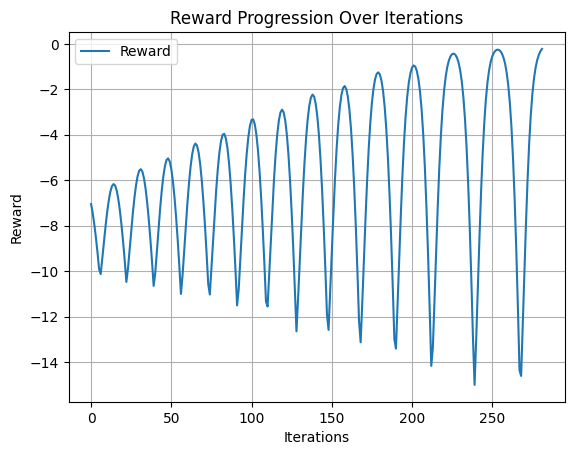

In [35]:
# Plot the reward progression
plt.plot(reward_list, label='Reward')
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Reward Progression Over Iterations')
plt.legend()
plt.grid(True)
plt.show()